<a href="https://colab.research.google.com/github/alanhelfer/alpr/blob/main/ALPR_01_UTPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO

### UTFPR - An Efficient and Layout-Independent Automatic License Plate Recognition System Based on the YOLO Detector

In [ ]:
!nvidia-smi

Sat Dec 11 15:36:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15376, done.
remote: Total 15376 (delta 0), reused 0 (delta 0), pack-reused 15376
Receiving objects: 100% (15376/15376), 13.98 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (10341/10341), done.


In [3]:
#change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [4]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

In [57]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

def imSave(path, lx, ty, w, h, name):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline
  image = cv2.imread(path)
  image_object = image[ty:ty+h, lx:lx+w] #left_x:  205   top_y:  154   width:  611   height:  367
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image_object, cv2.COLOR_BGR2RGB))
  plt.show()
  cv2.imwrite(name, image_object)

#### Download files

In [5]:
#Car detection
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/vehicle-detection.cfg
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/vehicle-detection.data
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/vehicle-detection.weights
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/vehicle-detection.names
#Plate detection
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-detection-layout-classification.cfg
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-detection-layout-classification.data
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-detection-layout-classification.weights
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-detection-layout-classification.names
#Plate recognition
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-recognition.cfg
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-recognition.data
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-recognition.weights
!wget http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/lp-recognition.names

--2021-12-11 15:53:12--  http://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/vehicle-detection.cfg
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/vehicle-detection.cfg [following]
--2021-12-11 15:53:13--  https://www.inf.ufpr.br/vri/databases/layout-independent-alpr/data/vehicle-detection.cfg
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2648 (2.6K) [application/octet-stream]
Saving to: ‘vehicle-detection.cfg’

vehicle-detection.c 100%[===================>]   2.59K  --.-KB/s    in 0s      

2021-12-11 15:53:13 (403 MB/s) - ‘vehicle-detection.cfg’ saved [2648/2648]

--2021-12-11 15:53:13--  http://www.inf.ufpr.br/vri/

In [77]:
#Image
!wget -c https://cdn.motor1.com/images/mgl/o8bnb/s1/volkswagen-gol-16-msi-at6-2019.jpg -O image.jpg

--2021-12-11 17:56:49--  https://cdn.motor1.com/images/mgl/o8bnb/s1/volkswagen-gol-16-msi-at6-2019.jpg
Resolving cdn.motor1.com (cdn.motor1.com)... 143.204.229.116, 143.204.229.27, 143.204.229.120, ...
Connecting to cdn.motor1.com (cdn.motor1.com)|143.204.229.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172749 (169K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 168.70K  --.-KB/s    in 0.01s   

2021-12-11 17:56:49 (13.9 MB/s) - ‘image.jpg’ saved [172749/172749]



#### Car detection

In [78]:
!./darknet detector test vehicle-detection.data vehicle-detection.cfg vehicle-detection.weights image.jpg -thresh .9 -ext_output #AIN6C48_f

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 416 x   3 ->  608 x 416 x  32 0.437 BF
   1 max                2x 2/ 2    608 x 416 x  32 ->  304 x 208 x  32 0.008 BF
   2 conv     64       3 x 3/ 1    304 x 208 x  32 ->  304 x 208 x  64 2.331 BF
   3 max                2x 2/ 2    304 x 208 x  64 ->  152 x 104 x  64 0.004 BF
   4 conv    128       3 x 3/ 1    152 x 104 x  64 ->  152 x 104 x 128 2.331 BF
   5 conv     64       1 x 1/ 1    152 x 104 x 128 ->  152 x 104 x  64 0.259 BF
   6 conv    128       3 x 3/ 1    152 x 104 x  64 ->  152 x 104 x 128 2.331 BF
   7 max                2x 2/ 2    152 x 104 x 128 ->   76 x  52 x 128

In [79]:
imShow('predictions.jpg')

In [80]:
#(left_x:  390   top_y:  181   width: 1067   height:  719)
imSave('image.jpg', 390, 181, 1067, 719, 'image_car.jpg')


#### Plate detection

In [81]:
!./darknet detector test lp-detection-layout-classification.data lp-detection-layout-classification.cfg lp-detection-layout-classification.weights -thresh .4 -ext_output image_car.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128

In [84]:
imShow('predictions.jpg')

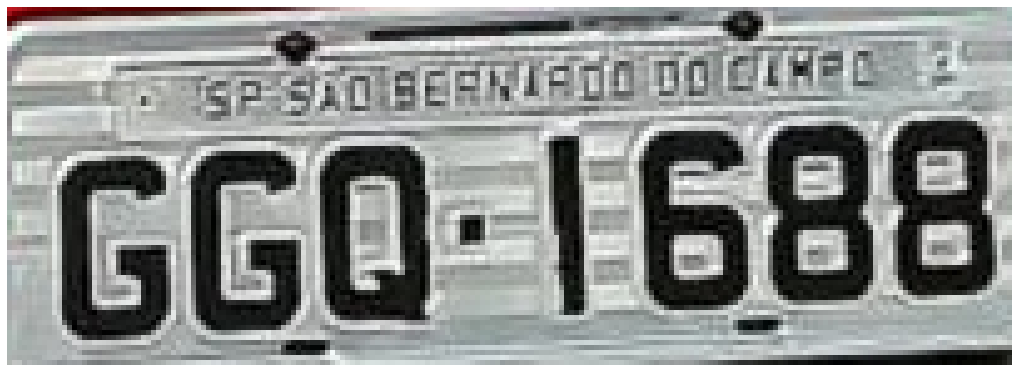

In [83]:
imSave('image_car.jpg', 647, 501, 202, 72, 'image_plate.jpg')


#### Plate recognition

In [85]:
!./darknet detector test lp-recognition.data lp-recognition.cfg lp-recognition.weights -thresh .5 -ext_output image_plate.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    352 x 128 x   3 ->  352 x 128 x  32 0.078 BF
   1 max                2x 2/ 2    352 x 128 x  32 ->  176 x  64 x  32 0.001 BF
   2 conv     64       3 x 3/ 1    176 x  64 x  32 ->  176 x  64 x  64 0.415 BF
   3 max                2x 2/ 2    176 x  64 x  64 ->   88 x  32 x  64 0.001 BF
   4 conv    128       3 x 3/ 1     88 x  32 x  64 ->   88 x  32 x 128 0.415 BF
   5 conv     64       1 x 1/ 1     88 x  32 x 128 ->   88 x  32 x  64 0.046 BF
   6 conv    128       3 x 3/ 1     88 x  32 x  64 ->   88 x  32 x 128 0.415 BF
   7 max                2x 2/ 2     88 x  32 x 128 ->   44 x  16 x 128

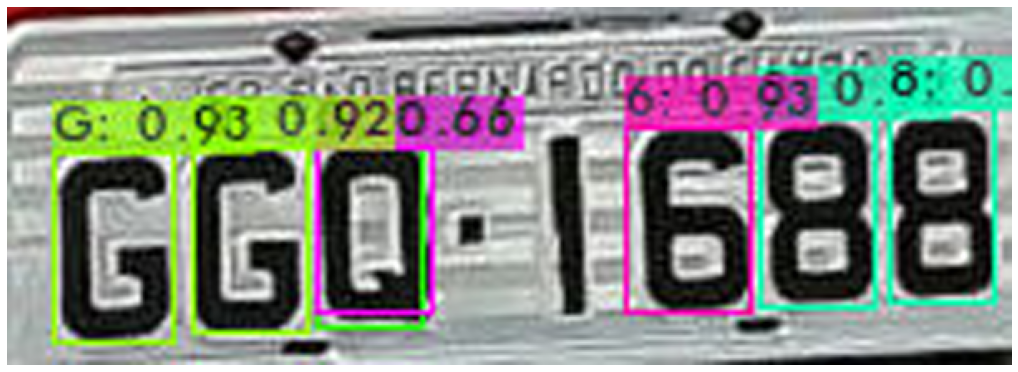

In [86]:
imShow('predictions.jpg')

#### End to end

--2021-12-11 18:01:41--  https://cdn.motor1.com/images/mgl/o8bnb/s1/volkswagen-gol-16-msi-at6-2019.jpg
Resolving cdn.motor1.com (cdn.motor1.com)... 143.204.229.120, 143.204.229.116, 143.204.229.27, ...
Connecting to cdn.motor1.com (cdn.motor1.com)|143.204.229.120|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 416 x   3 ->  608 x 416 x  32 0.437 BF
   1 max                2x 2/ 2    608 x 416 x  32 ->  304 x 208 x  32 0.008 BF
   2 conv     64       3 x 3/ 1    304 x 208 x  32 ->

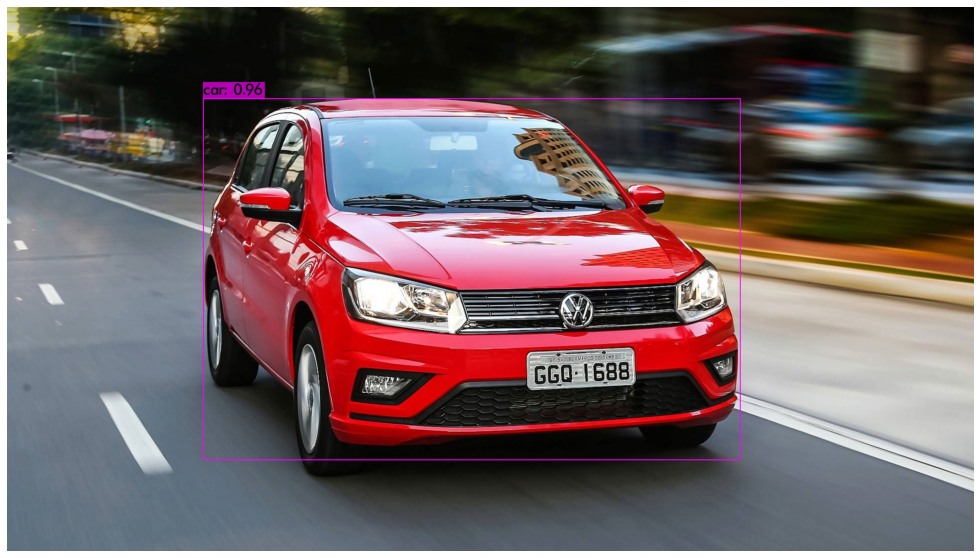

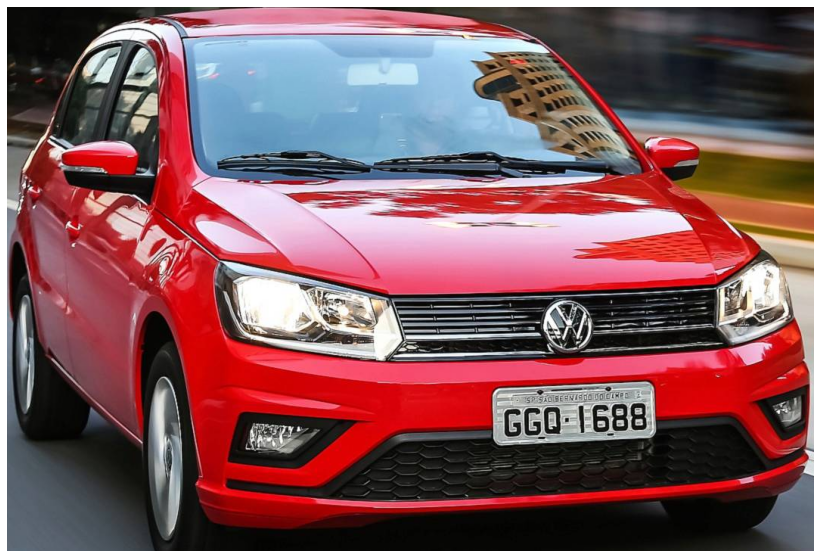

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128

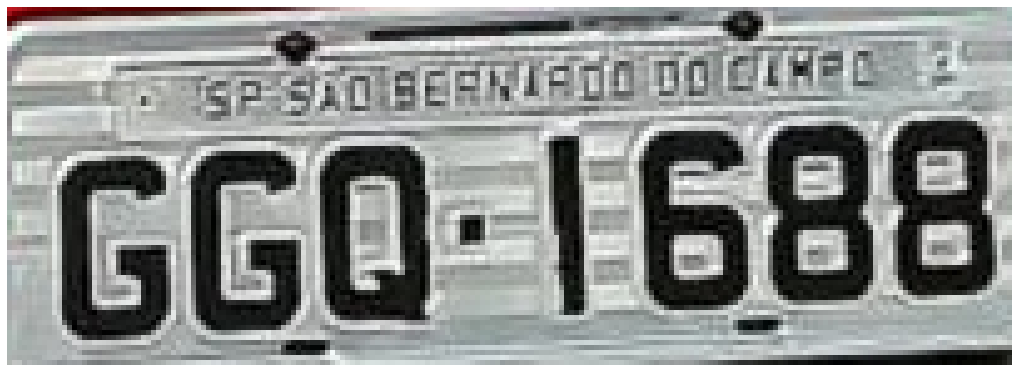

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    352 x 128 x   3 ->  352 x 128 x  32 0.078 BF
   1 max                2x 2/ 2    352 x 128 x  32 ->  176 x  64 x  32 0.001 BF
   2 conv     64       3 x 3/ 1    176 x  64 x  32 ->  176 x  64 x  64 0.415 BF
   3 max                2x 2/ 2    176 x  64 x  64 ->   88 x  32 x  64 0.001 BF
   4 conv    128       3 x 3/ 1     88 x  32 x  64 ->   88 x  32 x 128 0.415 BF
   5 conv     64       1 x 1/ 1     88 x  32 x 128 ->   88 x  32 x  64 0.046 BF
   6 conv    128       3 x 3/ 1     88 x  32 x  64 ->   88 x  32 x 128 0.415 BF
   7 max                2x 2/ 2     88 x  32 x 128 ->   44 x  16 x 128

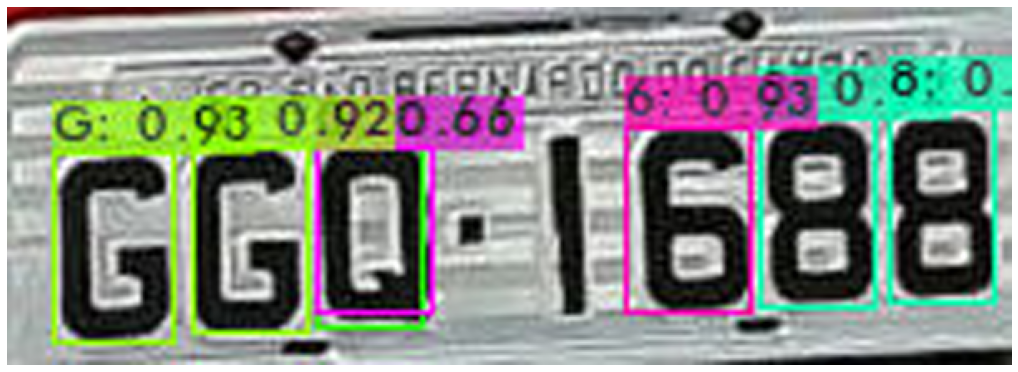

In [88]:
!wget -c https://cdn.motor1.com/images/mgl/o8bnb/s1/volkswagen-gol-16-msi-at6-2019.jpg -O imagem.jpg
!./darknet detector test vehicle-detection.data vehicle-detection.cfg vehicle-detection.weights imagem.jpg -thresh .9 -ext_output
imShow('predictions.jpg')
imSave('image.jpg', 390, 181, 1067, 719, 'image_car.jpg')
!./darknet detector test lp-detection-layout-classification.data lp-detection-layout-classification.cfg lp-detection-layout-classification.weights -thresh .4 -ext_output image_car.jpg
imSave('image_car.jpg', 647, 501, 202, 72, 'image_plate.jpg')
!./darknet detector test lp-recognition.data lp-recognition.cfg lp-recognition.weights -thresh .5 -ext_output image_plate.jpg
imShow('predictions.jpg')